# Tutorial 1: Computing $P_\ell(k)$ from Simulations

In this tutorial we will demonstrate how to use PolyBin3D to efficiently compute the power spectrum multipoles from simulations using the ``Pk_ideal`` and ``Pk_unwindowed`` functions. For now, we'll stick to idealized geometries with constant mask (*i.e.* the same background density everywhere) - non-trivial masks will be discussed in Tutorial 2.

### Preliminaries

We start by importing the packages we'll need, as well as defining some useful plotting functions.

In [1]:
%pylab inline
from nbodykit.lab import * # for creating testing data
from scipy.special import legendre
from scipy.interpolate import interp1d
import PolyBin3D as pb # the main code

def plotter(mat,axis=2,shift=True,vmax=None,title=''):
    """General purpose function for plotting a 3D density field, averaging over a specified axis. 
    
    We optionally apply an FFTshift operation, and truncate the plot to some symmetric range of values: [-vmax, vmax].
    """
    plt.figure()
    if shift:
        plot_mat = np.fft.fftshift(mat)
    else:
        plot_mat = mat
    to_plot = plot_mat.real.mean(axis=axis)
    if vmax is None:
        vmax = np.max(np.abs(to_plot))
    if len(title)>0:
        plt.title(title)
    plt.imshow(to_plot,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.colorbar();
    plt.show();
    
def plot_corr(f, v=1, subtract_identity=True, title=''):
    """Plot a correlation matrix, optionally subtracting the identity."""
    cfish = f/np.sqrt(np.outer(np.diag(f),np.diag(f)))
    plt.figure()
    if len(title)>0:
        plt.title(title)
    plt.imshow(cfish-subtract_identity*np.eye(len(cfish)),cmap=cm.RdBu_r,vmax=v,vmin=-v);
    plt.colorbar();
    
    plt.hlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.vlines(pspec.Nk-0.5, 0, 2*pspec.Nk, linestyles='--',alpha=0.5)
    plt.xlim(-0.5,2*pspec.Nk-0.5)
    plt.ylim(2*pspec.Nk-0.5,-0.5)
    plt.xlabel('Bin Index 1',fontsize=12)
    plt.ylabel('Bin Index 2',fontsize=12)

Populating the interactive namespace from numpy and matplotlib


### 1. Power Spectra from Periodic Boxes

As a first demonstration of PolyBin3D, we'll compute the power spectrum multipoles of a lognormal galaxy simulation. This has an ideal periodic geometry, so its power spectrum can be easily computed.  

To begin, we make some fake simulation data using Nbodykit; first we draw a lognormal sample of galaxies, then interpolate them to a grid, normalizing to obtain the fractional overdensity field, $\delta$. We could also feed in a continuous density field instead of the interpolated galaxy field (e.g. the matter density from a simulation, or a Gaussian random field).

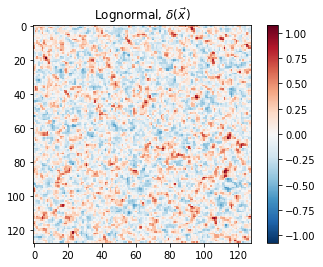

In [2]:
# Create a simple galaxy power spectrum
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0
fz = cosmo.scale_independent_growth_rate(redshift)
nbar = 3e-4

# Sample parameters
boxsize = 1000.
gridsize = 128

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)

# Add some redshift-space distortions along the z-axis
cat['Position'] += cat['VelocityOffset'] * [0,0,1]
cat['Position'] %= boxsize
cat['Position'] -= boxsize/2. # center on zero

# Convert the catalog to a grid, with TSC interpolation and interlacing
density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
density_grid -= 1.

# Let's plot the field
plotter(density_grid, title=r'Lognormal, $\delta(\vec x)$')

Next, we load PolyBin3D, optionally specifying a fiducial power spectrum monopole, which will be used as a weighting within each bin of the power spectrum estimator.

As before, we also need to decide the pixel window function, which accounts for the interpolation of discrete data onto the grid. The options are ``{'none','cic','tsc','pcs','interlaced-cic','interlaced-tsc','interlaced-pcs'}``. If no interpolation is used (e.g. for continuous simulation outputs), or if the density field is already pixel-window-corrected (e.g., using ``compensated=True`` above), then the pixel window should be set to ``'none'``.

In [3]:
# Define fiducial power spectrum (assuming the Kaiser formula)
k_arr = np.arange(0.001,1.,0.001)
Plin_arr = Plin(k_arr)
P0_arr = (b1**2 + 2./3.*b1*fz + 1./5.*fz**2.)*Plin_arr+1./nbar
P2_arr = (4./3.*b1*fz + 4./7.*fz**2.)*Plin_arr
P4_arr = 8./35.*fz**2*Plin_arr
Pk_theory = [k_arr, P0_arr, P2_arr, P4_arr]

# Define weighting, only using the monopole
Pk_fiducial = [k_arr, P0_arr]

# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=[0,0,0], # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='global', # line-of-sight [global = z-axis, local = relative to pair]
                )

### An aside: we can use PolyBin3D to create Gaussian random fields with the fiducial redshift-space power spectrum:
# density_grid = base.generate_data(seed=42, Pk_input = Pk_theory, output_type='real')


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


We can now proceed to compute power spectra. Here, we have periodic data without a mask, so we'll use the ``Pk_ideal`` power spectrum routines, computing spectra for $\ell\in\{0,2,4\}$. These weight the data by $1/P_{\rm fiducial}(k)$ to maximize signal-to-noise within each bin.  Note that the ideal estimators do not subtract any shot-noise contributions.

In [4]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(density_grid)

# Define the k-bin centers
k_cen = pspec.get_ks()

## Print number of FFTs used for diagnostics
print("\nComputations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))


Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Computing ideal Fisher matrix

Computations complete using 1 forward and 0 reverse FFTs


Let's look at the PolyBin3D power spectrum multipoles, and compare them to those from Nbodykit.

(-1000, 2400)

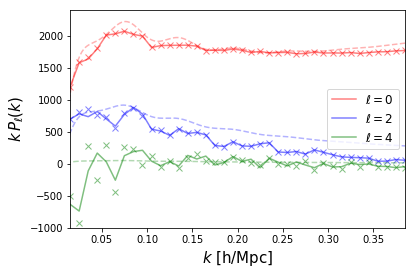

In [5]:
# Recompute the density-field with the pixel-window-compensation applied
density_mesh = cat.to_mesh(compensated=True, resampler='tsc', interlaced=True, position='Position')

# Compute the Nbodykit power spectrum in the same bins
r = FFTPower(density_mesh, mode='2d', kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*pk['p%d'%l],label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*pk_nb['power_%d'%l].real,c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*Pk_theory[l//2+1],c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))
plt.ylim(-1000,2400)

The agreement between the two codes is excellent! Slight differences occur for the quadrupole and hexadecapole since PolyBin3D accounts for leakage between different $\ell$-modes due to the discrete Fourier-space grid, which can be important at low-$k$. We can turn off these corrections by specifying ``discrete_correction=False`` in ``Pk_ideal()``.

We can also use PolyBin to compute the (Gaussian) covariance matrix, using the fiducial power spectrum monopole. This is shown below:

# Analyzing simulation 1 of 10
# Analyzing simulation 2 of 10
# Analyzing simulation 3 of 10
# Analyzing simulation 4 of 10
# Analyzing simulation 5 of 10
# Analyzing simulation 6 of 10
# Analyzing simulation 7 of 10
# Analyzing simulation 8 of 10
# Analyzing simulation 9 of 10
# Analyzing simulation 10 of 10


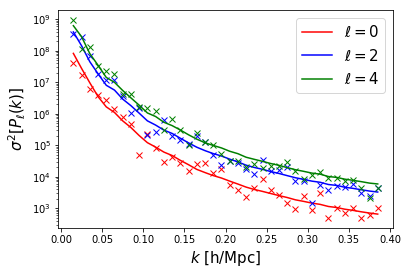

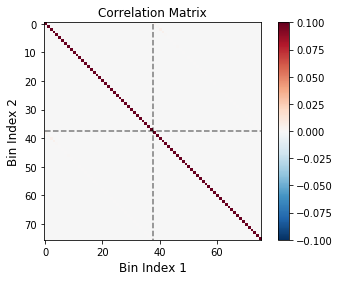

In [6]:
# Compute the empirical variances
pk_out = []
tot_sim = 10
for sim in range(tot_sim):
    print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=sim)

    # Add some redshift-space distortions along the z-axis
    cat['Position'] += cat['VelocityOffset'] * [0,0,1]
    cat['Position'] %= boxsize
    cat['Position'] -= boxsize/2. # center on zero

    # Convert the catalog to a grid, with CIC interpolation and interlacing
    density_grid = cat.to_mesh(compensated=False, resampler='tsc', interlaced=True, position='Position').compute()
    density_grid -= 1.
    
    # Compute the power spectra
    pk_out.append(pspec.Pk_ideal(density_grid))

# Compute variances
pk_var = {}
pk_var['p0'] = np.var([p['p0'] for p in pk_out],axis=0)
pk_var['p2'] = np.var([p['p2'] for p in pk_out],axis=0)
pk_var['p4'] = np.var([p['p4'] for p in pk_out],axis=0)

# Compute theoretical covariance
theory_covariance = pspec.inv_fish_ideal

# Plot variances
for l in range(0,lmax+1,2):
    plt.plot(k_cen,np.diag(theory_covariance)[l//2*pspec.Nk:(l//2+1)*pspec.Nk],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(k_cen,pk_var['p%d'%l],c=cols[l//2],marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15)
plt.ylabel(r'$\sigma^2\left[P_\ell(k)\right]$',fontsize=15)
plt.legend(fontsize=15);

# Plot correlation matrix
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
plot_corr(theory_corr, v=0.1, subtract_identity=False, title='Correlation Matrix')

The variances quite closely match the theoretical predictions (noting that we do not include contributions above the monopole). We also find slight off-diagonal correlation between multipoles even if there are no redshift-space distortions; this is induced by the discreteness effects (essentially the fact that $\int d\vec k\,L_\ell(\hat{k}\cdot\hat{z})L_{\ell'}(\hat{k}\cdot\hat{z})$ does not quite vanish for $\ell\neq \ell'$ on a finite grid).

### 2. FKP Power Spectra from Lightcones

Next, we'll consider a slightly more complex scenario: data with local lines-of-sight. In this approach, we compute the power spectrum multipoles with respect to the line-of-sight to a given pair of galaxies, using the Yamamoto estimator and FKP weights. This is appropriate for a light-cone geometry.

#### Create catalog

For testing, we'll create a simple lognormal catalog as before (from a periodic box centered at {0,0,0}, with redshift-space distortions along an arbitrary axis), then shift it along the line-of-sight.

In [7]:
# Define line-of-sight
los_vector = np.asarray([0.,np.sqrt(2./3.),np.sqrt(1./3.)])
boxcenter = cosmo.comoving_distance(redshift)*los_vector

# Sample parameters
boxsize = [1000.,1000.,1000.]
gridsize = [128,128,128]

# Create a lognormal catalog of galaxies using Nbodykit
cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=boxsize, Nmesh=gridsize, bias=b1, seed=42)
assert gridsize[0]==gridsize[1]==gridsize[2], "Lognormals need cubic geometries!"
assert boxsize[0]==boxsize[1]==boxsize[2], "Lognormals need cubic geometries!"

# Add some redshift-space distortions along the line-of-sight [x -> x + (v.n)n]
cat['Position'] += np.sum(cat['VelocityOffset'] * los_vector, axis=1)[:,None]*los_vector
cat['Position'] %= boxsize
cat['Position'] -= np.asarray(boxsize)/2. # center on zero

# Create a uniform catalog of randoms
cat_rand = UniformCatalog(nbar*50,boxsize,42)
cat_rand['Position'] -= np.asarray(boxsize)/2. # center on zero

# Add weight attributes
shape = 0.*cat['Position'][:,0]
shape_rand = 0.*cat_rand['Position'][:,0]
cat['WEIGHT_FKP'] = 1.+shape
cat['WEIGHT'] = 1.+shape
cat['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+shape
cat_rand['WEIGHT_FKP'] = 1.+shape_rand
cat_rand['WEIGHT'] = 1.+shape_rand
cat_rand['NZ'] = np.sum(cat['WEIGHT'])/np.asarray(boxsize).prod()+shape_rand

cat['TOT_WEIGHT'] = cat['WEIGHT']*cat['WEIGHT_FKP']
cat_rand['TOT_WEIGHT'] = cat_rand['WEIGHT']*cat_rand['WEIGHT_FKP']

#### Create density field

Given the catalog, let's create a 3D grid of overdensity $$d(\vec x) \equiv [n_g(\vec x)-n_r(\vec x)]/\sqrt{N}_2.$$
These will be fed-in to PolyBin3D. Here, we'll create the FKP catalog explicitly, though we note this can also be done directly with Nbodykit.

We'll use the standard FKP normalization factor $$N_2=\sum_{i\,\in\,\mathrm{data}} n_i w_{{\rm sys},i} w_{{\rm fkp},i}^2.$$

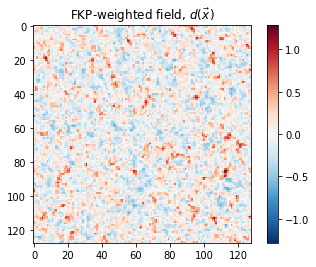

In [8]:
# Create data and random meshs
mesh_data = cat.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()
mesh_rand = cat_rand.to_mesh(Nmesh=gridsize, BoxSize=boxsize, interlaced=True, compensated=False, position='Position',
                       weight='TOT_WEIGHT', resampler='tsc').compute()

# Normalize fields
mesh_data = mesh_data*np.sum(cat['TOT_WEIGHT']).compute()
mesh_rand = mesh_rand*np.sum(cat_rand['TOT_WEIGHT']).compute()

# Define ratio of maps
alpha = (np.sum(cat['WEIGHT'])/np.sum(cat_rand['WEIGHT'])).compute()

# Compute output as [data - alpha * randoms]
density_fkp = (mesh_data - alpha*mesh_rand)

# Apply normalization
norm_dat = (cat['NZ']*cat['WEIGHT']*cat['WEIGHT_FKP']**2.).sum().compute()
density_fkp = density_fkp/np.sqrt(norm_dat*np.asarray(boxsize).prod())

# Plot the density field
plotter(density_fkp, title=r'FKP-weighted field, $d(\vec x)$')

#### Compute FKP power spectra

Now, we load PolyBin3D as before. We need to specify the center of the simulation box, and use ```local``` lines-of-sight (i.e. the Yamamoto approximation). Since we've applied the FKP normalization factor above, the rest of the computation proceeds exactly as before, using the ```pspec.Pk_ideal``` function.

In [9]:
# Load the PolyBin3D class
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=boxcenter, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )

# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.01)
lmax = 4

# Load the power spectrum class
pspec = pb.PSpec(base, k_edges, applySinv = None, mask = None, lmax = lmax)

# Compute the ideal power spectrum
pk = pspec.Pk_ideal(np.asarray(density_fkp))

## Print number of FFTs used for diagnostics
print("\nComputations complete using %d forward and %d reverse FFTs"%(base.n_FFTs_forward, base.n_FFTs_reverse))


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 1.17e+03, 8.26e+02] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc

Binning: 38 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics
Computing ideal Fisher matrix

Computations complete using 15 forward and 1 reverse FFTs


We can compare this to the standard Nbodykit Yamamoto power spectrum estimator:

In [10]:
# Recompute the density-field with the pixel-window-compensation applied, and shifting along the line-of-sight
cat_fkp_nb = FKPCatalog(cat.copy(), cat_rand.copy(), BoxSize=boxsize, BoxPad=0.)
cat_fkp_nb['data/Position'] += boxcenter
cat_fkp_nb['randoms/Position'] += boxcenter
density_mesh = cat_fkp_nb.to_mesh(Nmesh=gridsize, BoxCenter=boxcenter, interlaced=True, 
                               compensated=True,position='Position',
                               fkp_weight='WEIGHT_FKP', comp_weight='WEIGHT', resampler='tsc')

# Compute the Nbodykit power spectrum in the same bins
r = ConvolvedFFTPower(density_mesh, kmin=k_edges[0], kmax=k_edges[-1]+1e-4, dk = k_edges[1]-k_edges[0], poles=[0,2,4])
pk_nb = r.poles

Let's plot the result (subtracting shot-noise):

(0.015, 0.385)

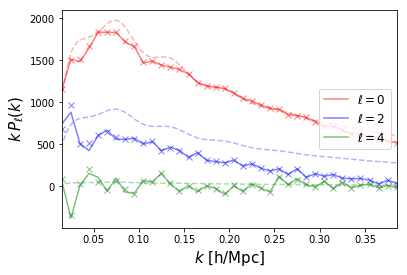

In [11]:
# Define the k-bin centers
k_cen = pspec.get_ks()


cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen, k_cen*(pk['p%d'%l]-(l==0)/nbar),label=r'$\ell=%d$'%l,c=cols[l//2],alpha=0.5,ls='-')
    plt.plot(k_cen, k_cen*(pk_nb['power_%d'%l].real-(l==0)/nbar),c=cols[l//2],alpha=0.5,ls='',marker='x')
    plt.plot(Pk_theory[0], Pk_theory[0]*(Pk_theory[l//2+1]-(l==0)/nbar),c=cols[l//2],alpha=0.3,ls='--')
plt.legend(fontsize=12,loc='center right');
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15);
plt.xlim(min(k_cen),max(k_cen))

The agreement between Nbodykit (crosses) and PolyBin3D (full lines) is excellent, as expected! The only differences are from the treatment of pixelation artefacts, which are a very small low-k effect. Note that the quadrupole is significantly smaller than the theory curve (dashed lines); this is because we generated data with a global line-of-sight and analyzed it with a local one!

### 3. Unwindowed Power Spectra from Lightcones

Finally, we'll compute the *unwindowed* power spectra from the data above using the ``Pk_unwindowed`` code. This is similar to the above, but properly accounts for the differing normalization due to the non-local line-of-sight and an arbitrary weighting scheme.

#### Setup dataset

For this exercise, we require the data field (normalized such that $d(\vec x) = n_g(\vec x)-\alpha n(\vec x)$) and a mask $n(\vec x)=\bar{n}$. 

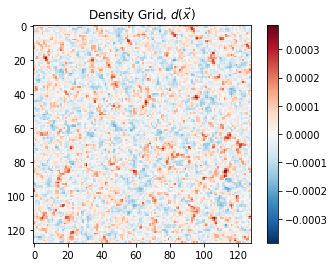

In [12]:
# Normalize density field to give *density* in each cell (like observational data)
density_grid = (mesh_data-alpha*mesh_rand)/np.asarray(boxsize).prod()

# Define a mask, i.e. the background density field
constant_mask = nbar

plotter(density_grid, title=r'Density Grid, $d(\vec x)$')

Now we set up PolyBin3D. This works just as before, and we assume a lightcone geometry, with local redshift-space axes and a sample displaced along the line-of-sight.

In [13]:
base = pb.PolyBin3D(boxsize, gridsize, Pk_fiducial, 
                 boxcenter=los_vector*10000, # center of the simulation volume
                 pixel_window='interlaced-tsc', # pixel window function
                 backend='fftw', # backend for performing FFTs
                 nthreads=4, # number of CPUs for performing FFTs
                 sightline='local', # line-of-sight [global = z-axis, local = relative to pair]
                )


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 8.16e+03, 5.77e+03] Mpc/h
# Line-of-sight: local
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: interlaced-tsc


#### Define Weighting

To compute the unwindowed power spectrum, we must additionally specify the weighting scheme $\mathsf{S}^{-1}$. This must take both real- and Fourier-space inputs, and apply some weighting in real- and/or Fourier-space. Ideally, $$\mathsf{S}^{-1} = \left[W\xi+\mathsf{I}\right]^{-1}$$ for window operator $W$ and data two-point function operator $\xi$. If the mask contains holes or local lines-of-sight, this cannot be computed analytically. We can either use an approximate weighting $\mathsf{S}^{-1}$ (which does not bias the estimator), or compute the full solution with conjugate gradient descent. 

Here, we demonstrate a simple form for constant-everywhere mask, using the redshift-space power spectrum, i.e.
$$\mathsf{S}^{-1}(\vec x,\vec y) = \int_{\vec k}e^{i\vec k\cdot(\vec x-\vec y)}\frac{1}{P(\vec k)}.$$

In [14]:
# Define the redshift-space power spectrum on the grid 
Pk_grid =  interp1d(k_arr,P0_arr, bounds_error=False)(base.modk_grid)
Pk_grid += interp1d(k_arr,P2_arr, bounds_error=False)(base.modk_grid)*legendre(2)(base.muk_grid)
Pk_grid += interp1d(k_arr,P4_arr, bounds_error=False)(base.modk_grid)*legendre(4)(base.muk_grid)

# Invert safely
k_weighting = np.zeros_like(Pk_grid)
k_weighting[(Pk_grid!=0)&(~np.isnan(Pk_grid))] = 1./Pk_grid[(Pk_grid!=0)&(~np.isnan(Pk_grid))]

# Add mean density
k_weighting /= nbar

def applySinv_simple(input_data, input_type='real', output_type='real'):
    """Apply a filter to the data."""
   
    # Read in the data, and convert it to Fourier-space if necessary
    if input_type=='real':
        input_fourier = base.to_fourier(input_data)
    else:
        input_fourier = input_data.copy()
    
    # Apply Fourier-space weighting
    Sinv_fourier = input_fourier*k_weighting
    
    # Return output in real- or Fourier-space
    if output_type=='real':
        return base.to_real(Sinv_fourier)
    else:
        return Sinv_fourier

#### Compute $P_\ell(k)$ 

Now we can compute the power spectra. This requires two pieces (a) the [Fisher] normalization matrix, $\mathcal{F}$, and (b) the power spectrum numerator, $\hat{q}$. These are combined according to $\mathcal{F}^{-1}\hat{q}$ (with optional shot-noise corrections).

We'll first compute the Fisher matrix using Monte Carlo methods. This can be expensive to compute (particularly in the Yamamoto approximation), and should usually be paralellized. Notably, this does *not* depend on the data, thus can be pre-computed. 

Here, we use 5 realizations for testing, computed via the ```compute_fisher_contribution``` routine. The whole computation can be wrapped via the ```compute_fisher``` method, which additionally allows for multi-processing.

In [15]:
# Define some k-bins and ell_max
k_edges = np.arange(0.01,0.4,0.02)
lmax = 4

# Load the power spectrum class, with our choice of weighting and mask
pspec = pb.PSpec(base, k_edges, applySinv = applySinv_simple, mask = constant_mask, lmax = lmax)

# Define the k-bin centers
k_cen = pspec.get_ks()

# Number of Monte Carlo iterations
N_it = 5

# Iterate over realizations
fish_and_shot = []
for s in range(N_it):
    print("Computing iteration %d of %d"%(s+1,N_it))
    fish_and_shot.append(pspec.compute_fisher_contribution(s,verb=(s==0)))
    
# Clean-up output
fish = np.mean([f[0] for f in fish_and_shot],axis=0)
fish_sd = np.std([f[0] for f in fish_and_shot],axis=0)

shot_num = np.mean([f[1] for f in fish_and_shot],axis=0)
shot_num_sd = np.std([f[1] for f in fish_and_shot],axis=0)

# # Alternative: compute all iterations, with optional multiprocessing
# fish, shot_num = pspec.compute_fisher(N_it, N_cpus=1, verb=True)


Binning: 19 bins in [0.010, 0.390] h/Mpc
l-max: 4
Mask: constant
Generating spherical harmonics
Computing iteration 1 of 5
Generating GRF
Computing Q[S^-1.W.a] maps
Computing S^-1.W.Q[A^-1.a] maps
Assembling Fisher matrix
Assembling shot-noise

Computing iteration 2 of 5
Computing iteration 3 of 5
Computing iteration 4 of 5
Computing iteration 5 of 5


We now compute the power spectrum, specifying the Fisher matrix and shot-noise numerator we just computed. We can optionally subtract off Poisson shot-noise from the estimator at this point. For comparison, we'll also compute the ideal power spectrum estimator here (just as before, but dropping the $N_2$ normalization term, for clarity).

In [16]:
# Compute unwindowed power spectrum
pk = pspec.Pk_unwindowed(density_grid, fish=fish, shot_num=shot_num, subtract_shotnoise=False)

# Compute ideal power spectrum
pk_ideal = pspec.Pk_ideal(density_grid) # this normalizes the field by < mask^2 > 
fish_ideal = pspec.fish_ideal

Computing ideal Fisher matrix


Let's look at the Fisher matrix. The diagonal elements are quite similar to those of the ideal estimator, though there are differences at the $\mathcal{O}(10\%)$ and the off-diagonals differ. This is because we have included anisotropy in the $\mathsf{S}^{-1}$ weighting (with the ideal estimator just using a monopole weighting), and have taken the local line-of-sight into account. The residual noise in the Fisher matrix can be reduced by using more Monte Carlo realizations to define the Fisher matrix; it scales as $1/N_{\rm it}$. 

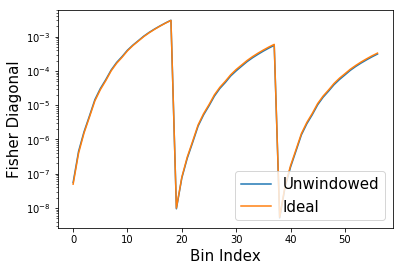

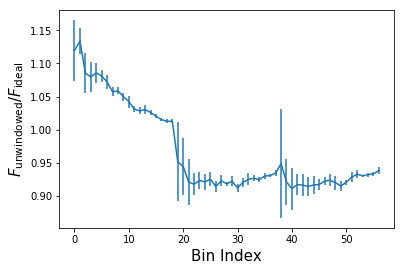

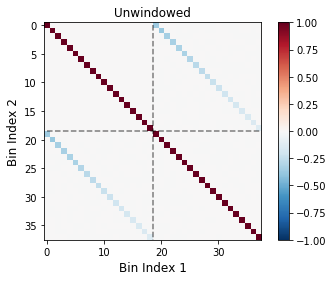

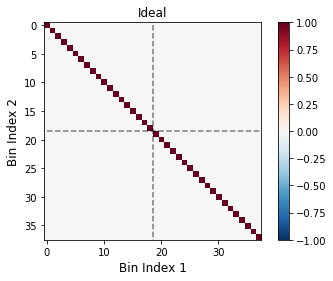

In [17]:
# Plot diagonals
plt.plot(np.diag(fish),label='Unwindowed')
plt.plot(np.diag(fish_ideal),label='Ideal')
plt.yscale('log')
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'Fisher Diagonal',fontsize=15)
plt.legend(fontsize=15);

# Plot ratios
plt.figure()
plt.errorbar(np.arange(pspec.N_bins),np.diag(fish)/np.diag(fish_ideal),yerr=np.diag(fish_sd)/np.diag(fish_ideal))
plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$F_{\rm unwindowed}/F_{\rm ideal}$',fontsize=15)

# Plot correlation matrices
plot_corr(fish, 1, subtract_identity=False, title='Unwindowed')
plot_corr(fish_ideal, 1, subtract_identity=False, title='Ideal')

Let's look at the spectra. We find excellent agreement for all correlators and for the shot-noise (which affects only the monopole, up to finite pixelation effects).

We note that these estimators are not *quite* identical in the uniform-mask limit. The unwindowed estimator additionally accounts for biases induced by the local line-of-sight, unlike the ideal estimator, which normalizes the power spectrum assuming the average line-of-sight to the sample. (In other words, the local 'Yamamoto' estimator is not strictly unbiased, even with a uniform window function.) Furthermore, and as above, our unwindowed estimator uses an anisotropic weighting, which is slightly closer to optimal than the isotropic weighting assumed in the ideal estimator.

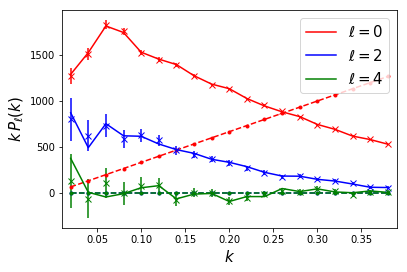

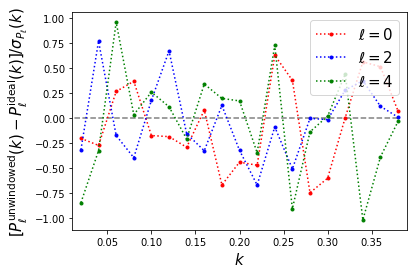

In [18]:
# Plot power spectra
ks = pspec.get_ks()
cs = ['r','b','g']
for l in [0,2,4]:
    plt.errorbar(ks,ks*(pk['p%d'%l]-(l==0)*1./nbar),color=cs[l//2],marker='x',ls='',
            yerr=ks*np.sqrt(np.diag(pspec.inv_fish))[l//2*pspec.Nk:(l//2+1)*pspec.Nk],)
    plt.plot(ks,ks*(pk_ideal['p%d'%l]-(l==0)*1./nbar),ls='-',color=cs[l//2],label=r'$\ell=%d$'%l)
    plt.plot(ks,ks*(pspec.shot[l//2*pspec.Nk:(l//2+1)*pspec.Nk]),color=cs[l//2],marker='.',ls='')
    plt.plot(ks,np.asarray(ks)/nbar*(l==0),ls='--',color=cs[l//2])
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k\,P_\ell(k)$',fontsize=15)
plt.legend(fontsize=15,loc='upper right');
plt.xlim(min(k_edges),max(k_edges));

# Plot ratios
plt.figure()
for l in [0,2,4]:
    plt.errorbar(ks,(pk['p%d'%l]-pk_ideal['p%d'%l])/np.sqrt(np.diag(pspec.inv_fish))[l//2*pspec.Nk:(l//2+1)*pspec.Nk],
                 ls=':',marker='.',color=cs[l//2],label=r'$\ell=%d$'%l)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$[P_\ell^{\rm unwindowed}(k)-P_\ell^{\rm ideal}(k)]/\sigma_{P_\ell}(k)$',fontsize=15)
plt.legend(fontsize=15,loc='upper right');
plt.hlines(0,max(ks),0,linestyles='--',alpha=0.5,color='k')
plt.xlim(min(k_edges),max(k_edges));

#### Compute Variances

Finally, let's test the optimality of our estimator. This can be done by creating a set of testing simulations and estimating their covariance matrix. If the $\mathsf{S}^{-1}$ weighting is optimal, the inverse Fisher matrix should match the covariance of the data.

Here, we'll test this using simple anisotropic Gaussian random field simulations. It's cheap to compute the power spectrum of each since we can reuse the Fisher matrix we computed earlier.

In [19]:
# Compute the empirical variances
pk_out_unwindowed = []

tot_sim = 25
for sim in range(tot_sim):
    if (sim+1)%5==0: print("# Analyzing simulation %d of %d"%(sim+1,tot_sim))
    
    # Generate an anisotropic Gaussian random field density map
    density_grid = base.generate_data(sim, Pk_theory)*nbar
    
    # Compute the power spectra
    pk_out_unwindowed.append(pspec.Pk_unwindowed(density_grid, subtract_shotnoise=False))
    
# Compute variances
pk_var = {}
pk_var['p0'] = np.var([p['p0'] for p in pk_out_unwindowed],axis=0)
pk_var['p2'] = np.var([p['p2'] for p in pk_out_unwindowed],axis=0)
pk_var['p4'] = np.var([p['p4'] for p in pk_out_unwindowed],axis=0)

# Compute theoretical covariance
theory_covariance = pspec.inv_fish

# Analyzing simulation 5 of 25
# Analyzing simulation 10 of 25
# Analyzing simulation 15 of 25
# Analyzing simulation 20 of 25
# Analyzing simulation 25 of 25


Let's look at the variances and correlations. The variances are in good agreement - this is as expected since we have included anisotropy in both the estimator weighting and the data. Up to noise, the covariances are also similar. Small differences may arise due to the differences between 'local' and 'global' lines of sight (as our GRF data is created with a global sightline, but analyzed with a local one), thus we do not expect our estimator to be entirely optimal.

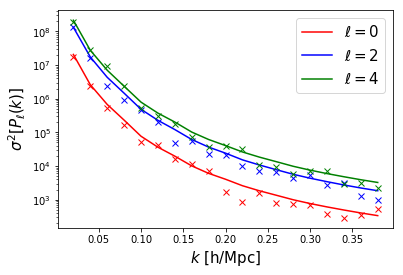

<Figure size 432x288 with 0 Axes>

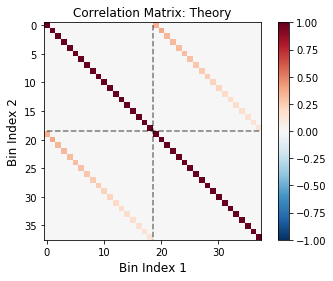

<Figure size 432x288 with 0 Axes>

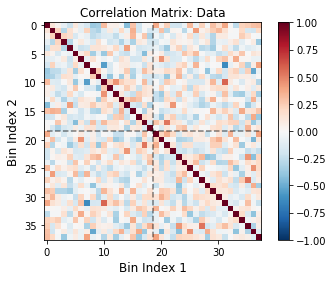

In [20]:
# Plot variances
cols = ['r','b','g']
for l in range(0,lmax+1,2):
    plt.plot(k_cen,np.diag(theory_covariance)[l//2*pspec.Nk:(l//2+1)*pspec.Nk],c=cols[l//2],label=r'$\ell=%d$'%l)
    plt.plot(k_cen,pk_var['p%d'%l],c=cols[l//2],marker='x',ls='')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]',fontsize=15)
plt.ylabel(r'$\sigma^2\left[P_\ell(k)\right]$',fontsize=15)
plt.legend(fontsize=15);

# Plot correlation matrix
theory_corr = theory_covariance/np.sqrt(np.outer(np.diag(theory_covariance),np.diag(theory_covariance)))
plot_corr(theory_corr, 1, subtract_identity=False, title='Correlation Matrix: Theory')

# Compute covariance
data_covariance = np.cov(np.asarray([np.hstack([p['p0'],p['p2'],p['p4']]) for p in pk_out_unwindowed]).T)

# Plot empirical matrix
data_corr = data_covariance/np.sqrt(np.outer(np.diag(data_covariance),np.diag(data_covariance)))
plot_corr(data_corr, 1, subtract_identity=False, title='Correlation Matrix: Data')

This completes the tutorial! In the other power spectrum tutorials, we'll (a) validate the unwindowed estimators by applying them to masked simulation data, and (b) apply them to the BOSS DR12 dataset.